## Preprocess images

In [1]:
from PIL import Image
from torchvision import transforms
import torch

def preprocess_image(bedroom_path: str, bathroom_path: str, kitchen_path: str, frontal_path: str) -> torch.Tensor:
    """
    This function receives the paths to the images and returns a tensor that can be used as input to the model.

    Parameters:
        - bedroom_path: str, path to the bedroom image.
        - bathroom_path: str, path to the bathroom image.
        - kitchen_path: str, path to the kitchen image.
        - frontal_path: str, path to the frontal image.

    Returns:
        - torch.Tensor, tensor that can be used as input to the model.
    """
    bathroom_image = Image.open(bathroom_path)
    bedroom_image = Image.open(bedroom_path)
    kitchen_image = Image.open(kitchen_path)
    frontal_image = Image.open(frontal_path)

    # Resize imagenes
    bathroom_image = bathroom_image.resize((200, 200))
    bedroom_image = bedroom_image.resize((200, 200))
    kitchen_image = kitchen_image.resize((200, 200))
    frontal_image = frontal_image.resize((200, 200))

    # Create mosaico
    mosaic = Image.new('RGB', (400, 400))
    mosaic.paste(bathroom_image, (0, 0))
    mosaic.paste(bedroom_image, (200, 0))
    mosaic.paste(kitchen_image, (0, 200))
    mosaic.paste(frontal_image, (200, 200))
    
    # Transformar imagen
    transform = transforms.Compose([
        transforms.Resize(256),                               # Redimensionar a 256x256
        transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
        transforms.ToTensor(),                                # Convertir la imagen a un tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),                            # Media de ImageNet
            (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
        )
    ])

    return transform(mosaic).unsqueeze(0)

## Preprocess numeric data

In [2]:
import pickle
import numpy as np


def preprocess_numeric_features(features: list, scaler_path: str) -> torch.Tensor:
    """
    This function receives the numeric features and the path to the 
    scaler object and returns a tensor that can be used as input to the model.

    Parameters:
        - features: list, list with the numeric features.
        - scaler_path: str, path to the scaler object.

    Returns:
        - torch.Tensor, tensor that can be used as input to the model.
    """

    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    features = scaler.transform([features])

    return torch.tensor(features, dtype=torch.float32)

## Load model and architecture

In [44]:
from torchvision import models
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Cargar el modelo preentrenado ResNet50
        self.image_features_ = models.resnet50(pretrained=True)

        # Eliminar la última capa de clasificación (fully connected) de ResNet50
        self.image_features_ = nn.Sequential(*list(self.image_features_.children())[:-1])

        # Procesamiento de las características numéricas (4 características)
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),   # Aquí usas 4 datos numéricos
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )

        # Capa final que combina las características visuales y numéricas
        self.combined_features_ = nn.Sequential(
            nn.Linear(2048 + 64*3*3, 64*3*3*2*2),  # 2048 provienen de ResNet50 + numéricas
            nn.GELU(),  # GELU
            nn.Dropout(),
            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.GELU(),  # GELU
            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),  # Predicción final
        )

    def forward(self, x, y):
        # Pasar las imágenes por ResNet50 para obtener las características visuales
        x = self.image_features_(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)

        # Pasar las características numéricas por la red densa
        y = self.numeric_features_(y)

        # Combinar características visuales y numéricas
        z = torch.cat((x, y), dim=1)
        # print(z.shape)

        # Pasar las características combinadas por las capas finales
        z = self.combined_features_(z)

        return z.squeeze(1)

In [45]:
import torch

# Define the paths
ruta_modelo = '../models/'
nombre_modelo = 'model_resnet50_l2_lambda10.pth'

# Load model
model = torch.load(f"{ruta_modelo}{nombre_modelo}", map_location=torch.device('cpu'))
model.eval()

NeuralNetwork(
  (image_features_): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Predict the price of many houses

In [73]:
import pandas as pd

df_test = pd.read_csv('../dataset/Mosaico/test.csv')
mosaic_image = df_test['mosaic_image']
mosaic_image = mosaic_image.str.replace('.png', '')
df_test['mosaic_image'] = mosaic_image
df_test.head()

,bedrooms,bathrooms,area,zipcode,mosaic_image,price
0,5,5.0,4014,92880,301,542000
1,5,3.0,2179,94531,520,430000
2,3,2.0,1200,60016,79,224900
3,4,2.5,3060,91901,83,699999
4,4,2.0,1881,96019,153,245000


In [74]:
import warnings
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*")


scaler_path = '../models/scaler.pkl'
predictions_list = []
true_prices = []

for index, row in df_test.iterrows():
    # if row['mosaic_image'] == '0':
    #     continue
    bedroom_path = f"../dataset/Houses-dataset/Houses Dataset/{row['mosaic_image']}_bedroom.jpg"
    bathroom_path = f"../dataset/Houses-dataset/Houses Dataset/{row['mosaic_image']}_bathroom.jpg"
    kitchen_path = f"../dataset/Houses-dataset/Houses Dataset/{row['mosaic_image']}_kitchen.jpg"
    frontal_path = f"../dataset/Houses-dataset/Houses Dataset/{row['mosaic_image']}_frontal.jpg"

    image_tensor = preprocess_image(bedroom_path, bathroom_path, kitchen_path, frontal_path)

    numeric_features = [row['bedrooms'], row['bathrooms'], row['area'], row['zipcode']]
    numeric_tensor = preprocess_numeric_features(numeric_features, scaler_path)

    with torch.no_grad():
        prediction = model(image_tensor, numeric_tensor).item()
    
    predictions_list.append(prediction)
    true_prices.append(row['price'])

    print(f"Index: {index}: Predicted house price: ${prediction:.2f} - Real house price: ${row['price']:.2f}")

Index: 0: Predicted house price: $620564.12 - Real house price: $542000.00
Index: 1: Predicted house price: $531066.31 - Real house price: $430000.00
Index: 2: Predicted house price: $236962.34 - Real house price: $224900.00
Index: 3: Predicted house price: $549620.25 - Real house price: $699999.00
Index: 4: Predicted house price: $194874.17 - Real house price: $245000.00
Index: 5: Predicted house price: $728776.44 - Real house price: $599900.00
Index: 6: Predicted house price: $441728.12 - Real house price: $495000.00
Index: 7: Predicted house price: $556179.38 - Real house price: $545000.00
Index: 8: Predicted house price: $993650.00 - Real house price: $799000.00
Index: 9: Predicted house price: $613559.94 - Real house price: $850000.00
Index: 10: Predicted house price: $662798.31 - Real house price: $529000.00
Index: 11: Predicted house price: $81763.50 - Real house price: $104950.00
Index: 12: Predicted house price: $116356.30 - Real house price: $158888.00
Index: 13: Predicted ho

In [75]:
total_absolute_error = 0
total_percentage_error = 0

for x in range(0, len(predictions_list)):
    valor_predicho = predictions_list[x]
    valor_real = true_prices[x]

    # Calculate the absolute error and the percentage error
    error_absoluto = abs(valor_predicho - valor_real)
    error_porcentual = (error_absoluto / valor_real) * 100

    total_absolute_error += error_absoluto
    total_percentage_error += error_porcentual

    print(f"{x+2 }.-Error Absoluto: ${error_absoluto:.2f} - Error Porcentual: {error_porcentual:.2f}%")

2.-Error Absoluto: $78564.12 - Error Porcentual: 14.50%
3.-Error Absoluto: $101066.31 - Error Porcentual: 23.50%
4.-Error Absoluto: $12062.34 - Error Porcentual: 5.36%
5.-Error Absoluto: $150378.75 - Error Porcentual: 21.48%
6.-Error Absoluto: $50125.83 - Error Porcentual: 20.46%
7.-Error Absoluto: $128876.44 - Error Porcentual: 21.48%
8.-Error Absoluto: $53271.88 - Error Porcentual: 10.76%
9.-Error Absoluto: $11179.38 - Error Porcentual: 2.05%
10.-Error Absoluto: $194650.00 - Error Porcentual: 24.36%
11.-Error Absoluto: $236440.06 - Error Porcentual: 27.82%
12.-Error Absoluto: $133798.31 - Error Porcentual: 25.29%
13.-Error Absoluto: $23186.50 - Error Porcentual: 22.09%
14.-Error Absoluto: $42531.70 - Error Porcentual: 26.77%
15.-Error Absoluto: $20888.42 - Error Porcentual: 15.03%
16.-Error Absoluto: $77290.88 - Error Porcentual: 8.14%
17.-Error Absoluto: $68225.94 - Error Porcentual: 13.65%
18.-Error Absoluto: $24474.91 - Error Porcentual: 4.80%
19.-Error Absoluto: $117516.00 - Erro

In [76]:
print(f"[+] Promedio de error absoluto: {total_absolute_error/len(predictions_list)}")
print(f"[+] Promedio de error porcentual: {total_percentage_error/len(predictions_list)}")

[+] Promedio de error absoluto: 69083.37991431452
[+] Promedio de error porcentual: 13.798339520581292


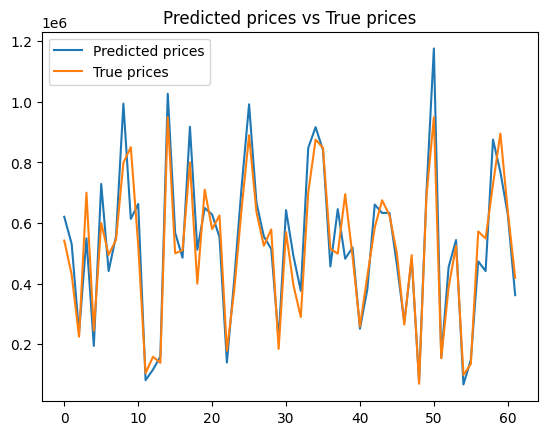

In [81]:
# Graficar los errores
import matplotlib.pyplot as plt

plt.plot(predictions_list, label='Predicted prices')
plt.plot(true_prices, label='True prices')
plt.title('Predicted prices vs True prices')
plt.legend()
plt.show()


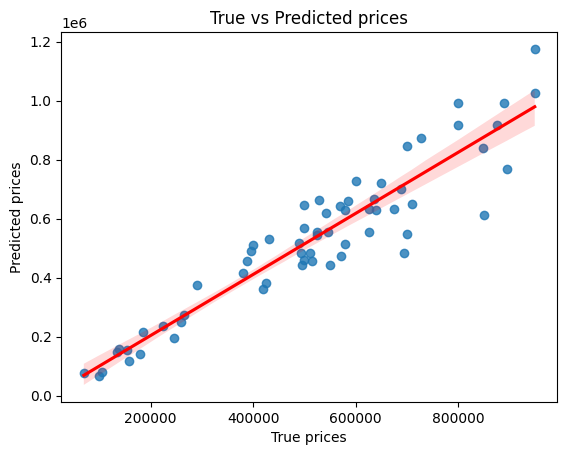

In [80]:
# Graficar precios predichos y linea de regresión
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x=true_prices, y=predictions_list, line_kws={"color": "red"})
plt.xlabel('True prices')
plt.ylabel('Predicted prices')
plt.title('True vs Predicted prices')
plt.show()
